# 4. Predicting the whole Kano and Yoshii River
*Written by Men Vuthy, 2022*

---

**Import modules**

In [2]:
import os
import pandas as pd
import numpy as np
np.random.seed(0)

import rasterio
import geopandas as gpd

# Import scikit-learn modules
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)

In [3]:
# Input classified data of each river
Kano_classified = pd.read_csv('data/kano_river/out_img/classified/kano_classified_index.csv')
Yoshii_classified = pd.read_csv('data/yoshii_river/out_img/classified/yoshii_classified_index.csv')

In [4]:
# Get index of dataframe
kano_index = Kano_classified.iloc[:,0]
yoshii_index = Yoshii_classified.iloc[:,0]

# Create a list of the feature column's names
features = Kano_classified.columns[1:29]

features

Index(['B1', 'G1', 'R1', 'NIR1', 'NDVI1', 'NDWI1', 'BSI1', 'B2', 'G2', 'R2',
       'NIR2', 'NDVI2', 'NDWI2', 'BSI2', 'B3', 'G3', 'R3', 'NIR3', 'NDVI3',
       'NDWI3', 'BSI3', 'B4', 'G4', 'R4', 'NIR4', 'NDVI4', 'NDWI4', 'BSI4'],
      dtype='object')

In [5]:
# load, no need to initialize the loaded_rf
rfc_model = joblib.load("./random_forest_150ensembles.joblib")

In [6]:
# Apply the trained Classifier to the prediction dataframe
preds_kano = rfc_model.predict(Kano_classified[features])

In [7]:
# View accuracy classification (cross-validation) score
print('Our classification accuracy is: {cv}%'.format(cv=accuracy_score(Kano_classified['label'], preds_kano)* 100))

Our classification accuracy is: 62.65113846811683%


*Visualizing confusion matrix*

In [8]:
# Get and reshape confusion matrix data
Matrix = confusion_matrix(Kano_classified['label'], preds_kano)
matrix = Matrix.astype('float') / Matrix.sum(axis=1)[:, np.newaxis]

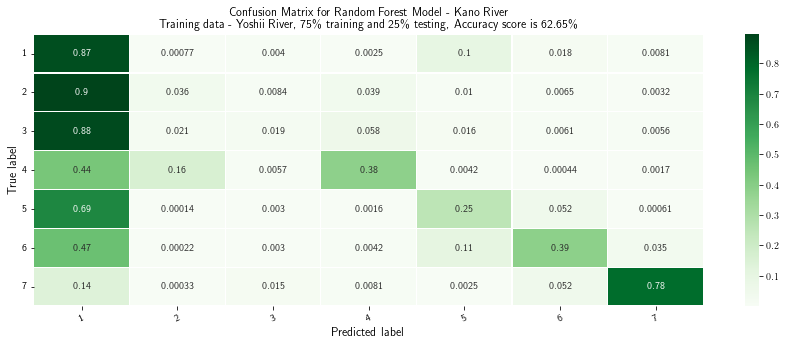

In [12]:
# Build the plot
plt.figure(figsize=(15,5))
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['1', '2', '3', '4', '5', '6', '7']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks+ 0.5, class_names, rotation=25, fontsize=10)
plt.yticks(tick_marks2, class_names, rotation=0, fontsize=10)
plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.title('Confusion Matrix for Random Forest Model - Kano River\nTraining data - Yoshii River, 75\% training and 25\% testing, Accuracy score is 62.65\%')
plt.savefig('data/kano_river/out_img/predicted/confusion-matrix-yoshii-data.png', dpi=300)
plt.show()

In [13]:
# Apply the trained Classifier to the prediction dataframe
preds_yoshii = rfc_model.predict(Yoshii_classified[features])

In [14]:
# View accuracy classification (cross-validation) score
print('Our classification accuracy is: {cv}%'.format(cv=accuracy_score(Yoshii_classified['label'], preds_yoshii)* 100))

Our classification accuracy is: 97.14559784074636%


*Visualizing confusion matrix*

In [15]:
# Get and reshape confusion matrix data
Matrix = confusion_matrix(Yoshii_classified['label'], preds_yoshii)
matrix = Matrix.astype('float') / Matrix.sum(axis=1)[:, np.newaxis]

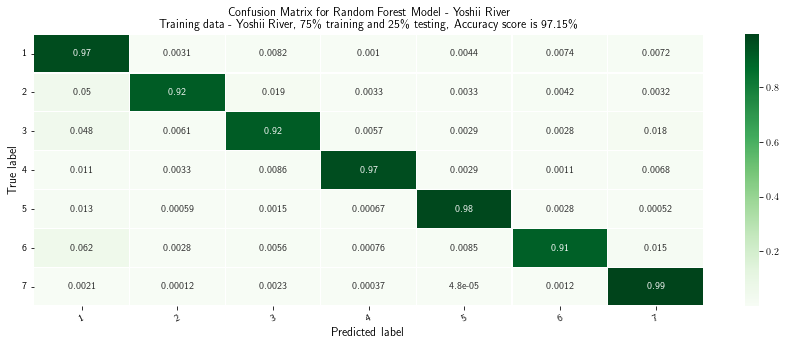

In [17]:
# Build the plot
plt.figure(figsize=(15,5))
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['1', '2', '3', '4', '5', '6', '7']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks+ 0.5, class_names, rotation=25, fontsize=10)
plt.yticks(tick_marks2, class_names, rotation=0, fontsize=10)
plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.title('Confusion Matrix for Random Forest Model - Yoshii River\nTraining data - Yoshii River, 75\% training and 25\% testing, Accuracy score is 97.15\%')
plt.savefig('data/yoshii_river/out_img/predicted/confusion-matrix-yoshii-data.png', dpi=300)
plt.show()

**Create raster of predicted data - Kano river**

In [10]:
# Add one image for projection and shape reference
kano_img = rasterio.open("data/kano_river/out_img/class/kano_class.tiff")

In [11]:
# Create new dataframe for predicted class and its index
rfc_class = pd.DataFrame()
rfc_class['id'] = kano_index
rfc_class['class'] = preds_kano

In [12]:
# Rearrange index into shape of reference raster
indx = list(range(kano_img.read().reshape(-1).shape[0]))
Index = pd.DataFrame()
Index['id'] = indx
df1 = Index.set_index('id')
df2 = rfc_class.set_index('id')
df2 = rfc_class.set_index(df2.index.astype('int64')).drop(columns=['id'])
mask = df2.index.isin(df1.index)
df1['cluster'] = df2.loc[mask, 'class']

In [13]:
# Reshape the cluster array
array = np.array(df1['cluster'])
n_array = array.reshape(kano_img.read().shape)
class_array = np.where(np.isnan(n_array), 0, n_array)

In [14]:
# Data dir
data_dir = "data/kano_river/out_img/predicted"

# Output raster
out_tif = os.path.join(data_dir, "kano_predicted_yoshii.tif")

# Copy the metadata
out_meta = kano_img.meta.copy()
out_meta

# Update the metadata
out_meta.update({'driver': 'GTiff',
                 'dtype': 'float32',
                 'nodata': None,
                 'width': kano_img.shape[1],
                 'height': kano_img.shape[0],
                 'crs': kano_img.crs,
                 'count':1,
                 'transform': kano_img.transform
                })

with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(class_array.astype(np.float32))

**Create raster of predicted data - Yoshii river**

In [15]:
# Add one image for projection and shape reference
yoshii_img = rasterio.open("data/yoshii_river/out_img/class/yoshii_class.tiff")

In [16]:
# Create new dataframe for predicted class and its index
rfc_class = pd.DataFrame()
rfc_class['id'] = yoshii_index
rfc_class['class'] = preds_yoshii

In [17]:
# Rearrange index into shape of reference raster
indx = list(range(yoshii_img.read().reshape(-1).shape[0]))
Index = pd.DataFrame()
Index['id'] = indx
df1 = Index.set_index('id')
df2 = rfc_class.set_index('id')
df2 = rfc_class.set_index(df2.index.astype('int64')).drop(columns=['id'])
mask = df2.index.isin(df1.index)
df1['cluster'] = df2.loc[mask, 'class']

In [18]:
# Reshape the cluster array
array = np.array(df1['cluster'])
n_array = array.reshape(yoshii_img.read().shape)
class_array = np.where(np.isnan(n_array), 0, n_array)

In [19]:
# Data dir
data_dir = "data/yoshii_river/out_img/predicted"

# Output raster
out_tif = os.path.join(data_dir, "yoshii_predicted_yoshii.tif")

# Copy the metadata
out_meta = yoshii_img.meta.copy()
out_meta

# Update the metadata
out_meta.update({'driver': 'GTiff',
                 'dtype': 'float32',
                 'nodata': None,
                 'width': yoshii_img.shape[1],
                 'height': yoshii_img.shape[0],
                 'crs': yoshii_img.crs,
                 'count':1,
                 'transform': yoshii_img.transform
                })

with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(class_array.astype(np.float32))